This notebook will attempt to explore how firing up the different instruments at different times might impact the estimates of the dust flux.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"
aspect_ratio = 16./9

# These data files come from ~/research/pubs/grants/2022/MDAP-2022/Data/Met_Signal_Figure.ipynb.
pres_data_filename = "Met_Signal_Figure_pressure_data.csv"
RDS_data_filename = "Met_Signal_Figure_RDS_data.csv"
wind_data_filename = "Met_Signal_Figure_wind_data.csv"

In [24]:
# Fit functions

def modified_lorentzian(t, baseline, slope, t0, Delta, Gamma):
    """
    Pressure profile for a vortex

    Args:
        t (float array): time
        baseline (float): baseline against which vortex excursion
        occurs
        slope (float): slope against which excursion occurs
        t0 (float): central time for vortex excursion
        Delta (float): magnitude of excursion
        Gamma (float): full-width/half-max duration of excursion

    Returns:
        Signal for a vortex (float array)

    """
    # Equation 7 from Kahapaa+ (2016)
    return baseline + slope*(t - t0) - Delta/(((t - t0)/(Gamma/2.))**2 + 1)

def wind_profile(t, t0, Vobs, U1, U2, b, Gamma_obs):

    Vr = Vobs*np.sqrt(1. + U1**2*(t - t0)**2/b**2)/(1. + (2.*(t - t0)/Gamma_obs)**2)
#   Vr_cos = np.sign(b)*Vobs/(1. + (2.*(t - t0)/Gamma_obs)**2)
    Vr_cos = Vobs/(1. + (2.*(t - t0)/Gamma_obs)**2)
    ret_val = np.sqrt(Vr**2 + 2.*U1*Vr_cos + U1**2)

    ind = t > t0

    Vr[ind] = Vobs*np.sqrt(1. + U2**2*(t[ind] - t0)**2/b**2)/(1. + (2.*(t[ind] - t0)/Gamma_obs)**2)
#   Vr_cos[ind] = np.sign(b)*Vobs/(1. + (2.*(t[ind] - t0)/Gamma_obs)**2)
    Vr_cos[ind] = Vobs/(1. + (2.*(t[ind] - t0)/Gamma_obs)**2)
    ret_val[ind] = np.sqrt(Vr[ind]**2 + 2.*U2*Vr_cos[ind] + U2**2)

    return ret_val

# def fit_wind_profile(t, wind, sigma, t0, Gamma, p0, num_gammas=3.):

#     U1 = np.nanmedian(wind[t < t0 - num_gammas*Gamma])
#     U2 = np.nanmedian(wind[t > t0 + num_gammas*Gamma])

#     popt, pcov = curve_fit(lambda t, fit_Vobs, fit_b:\
#             wind_profile(t, t0, fit_Vobs, U1, U2, fit_b, Gamma),
#             t, wind, p0=p0, sigma=sigma*np.ones_like(t))
#     uncertainties = np.sqrt(np.diag(pcov))

#     return popt, uncertainties, U1, U2

def fit_wind_profile(t, wind, sigma, t0, init_Gamma, p0, num_gammas=3.):

    U1 = np.nanmedian(wind[t < t0 - num_gammas*init_Gamma])
    U2 = np.nanmedian(wind[t > t0 + num_gammas*init_Gamma])

    popt, pcov = curve_fit(lambda t, fit_Vobs, fit_b, fit_Gamma:\
            wind_profile(t, t0, fit_Vobs, U1, U2, fit_b, fit_Gamma),
            t, wind, p0=p0, sigma=sigma*np.ones_like(t))
    uncertainties = np.sqrt(np.diag(pcov))

    return popt, uncertainties, U1, U2

[1.04581781e+01 2.89079479e+04 1.47532807e+01] 2.04 5.2


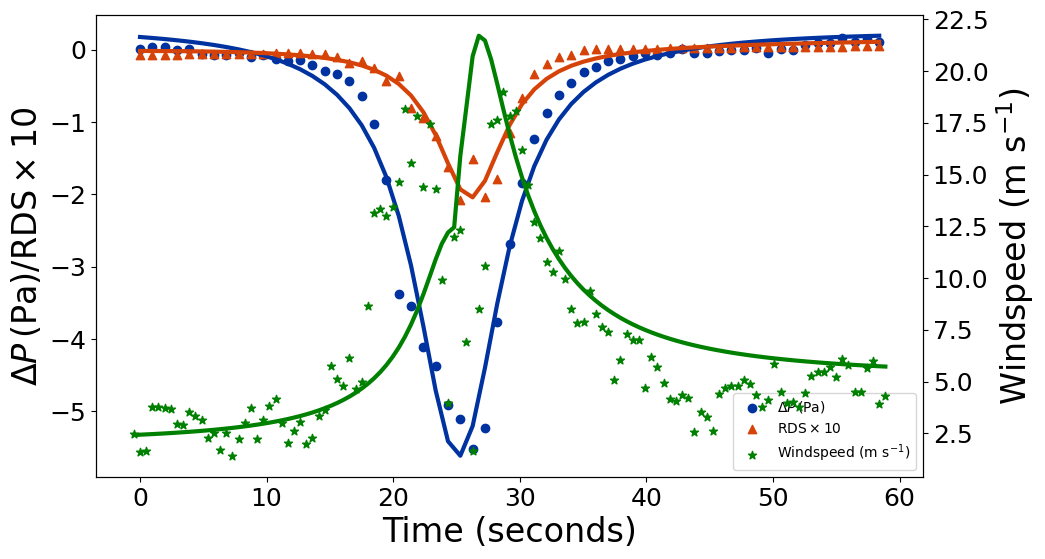

In [29]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

pres_data = np.genfromtxt(pres_data_filename, names=['time', 'Delta_P'], delimiter=',')
RDS_data = np.genfromtxt(RDS_data_filename, names=['time', 'RDS'], delimiter=',')
wind_data = np.genfromtxt(wind_data_filename, names=['time', 'windspeed'], delimiter=',')

# Estimate the point-to-point scatter
sigma_pres = np.median(np.abs(np.diff(pres_data['Delta_P'])))
sigma_RDS = np.median(np.abs(np.diff(RDS_data['RDS'])))
sigma_wind = np.median(np.abs(np.diff(wind_data['windspeed'])))

ax1.scatter(pres_data['time'], pres_data['Delta_P'], marker='o', color=BoiseState_blue, 
               label=r'$\Delta P\,\left( {\rm Pa} \right)$')
ax1.scatter(RDS_data['time'], RDS_data['RDS']*10, marker='^', color=BoiseState_orange, 
                label=r'${\rm RDS} \times 10$')
ax1.scatter([], [], marker='*', color='green', label=r'Windspeed (${\rm m\ s^{-1}}$)')
ax2.scatter(wind_data['time'], wind_data['windspeed'], marker='*', color='green',
               label=r'Windspeed (${\rm m\ s^{-1}}$)')

ax1.tick_params(labelsize=18)
ax1.legend(loc='lower right')
ax1.set_xlabel("Time (seconds)", fontsize=24)
ax1.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)/{\rm RDS} \times 10$', fontsize=24)
ax2.tick_params(labelsize=18, axis='y')
ax2.set_ylabel(r'Windspeed (${\rm m\ s^{-1}}$)', fontsize=24)

#### Model fits ####

# pressure
# initial guesses by eye
pres_popt, pres_pcov = curve_fit(modified_lorentzian, pres_data['time'], pres_data['Delta_P'], 
                       sigma=sigma_pres, p0=[0., 0., np.median(pres_data['time']), 5.5, 6.])
# parameter uncertainties taken to be the sqrt of the diagonal of the cov matrix
pres_unc = np.sqrt(np.diag(pres_pcov))
fixed_t0 = pres_popt[2]
fixed_gamma = pres_popt[4]

ax1.plot(pres_data['time'], modified_lorentzian(pres_data['time'], *pres_popt), lw=3, color=BoiseState_blue)

# RDS
RDS_popt, RDS_pcov = curve_fit(modified_lorentzian, RDS_data['time'], RDS_data['RDS'], 
                       sigma=sigma_RDS, p0=[0., 0., np.median(pres_data['time']), 5.5, 6.])
ax1.plot(pres_data['time'], modified_lorentzian(RDS_data['time'], *RDS_popt)*10, lw=3, color=BoiseState_orange)

# fit_wind_profile(t, wind, sigma, t0, Gamma, p0, num_gammas=3.)

wind_popt, wind_uncertainties, U1, U2 = fit_wind_profile(wind_data['time'], wind_data['windspeed'], 
                                               sigma_wind, fixed_t0, fixed_gamma, [20., 1., fixed_gamma], num_gammas=3.)
print(wind_popt, U1, U2)
ax2.plot(wind_data['time'], wind_profile(wind_data['time'], fixed_t0, wind_popt[0], U1, U2, 3., fixed_gamma/2), 
         color='green', lw=3)
                                               
# Estimating the wind profile parameters - we're going to cheat a bit using a Lorenztian for each limb
# before_wind_ind = wind_data['time'] <= fixed_t0
# wind_popt, wind_unc = curve_fit(lambda time, baseline, slope, Delta, Gamma: 
#                                 modified_lorentzian(time, baseline, slope, 
#                                                     wind_data['time'][before_wind_ind][np.argmax(wind_data['windspeed'][before_wind_ind])], 
#                                                     Delta, Gamma), 
#                                 wind_data['time'][before_wind_ind], wind_data['windspeed'][before_wind_ind], 
#                        sigma=sigma_wind, p0=[0., 0., -15., 1.])
# ax2.plot(wind_data['time'][before_wind_ind], 
#          modified_lorentzian(wind_data['time'][before_wind_ind], wind_popt[0], wind_popt[1], 
#                                                                   wind_data['time'][before_wind_ind][np.argmax(wind_data['windspeed'][before_wind_ind])],
#          wind_popt[2], wind_popt[3]), lw=3, color='green')
# print(wind_popt)
# # Estimating corresponding dust flux

# after_wind_ind = wind_data['time'] > fixed_t0
# wind_popt, wind_unc = curve_fit(lambda time, baseline, slope, Delta, Gamma: 
#                                 modified_lorentzian(time, baseline, slope, 
#                                                     wind_data['time'][after_wind_ind][np.argmax(wind_data['windspeed'][after_wind_ind])], 
#                                                     Delta, Gamma), 
#                                 wind_data['time'][after_wind_ind], wind_data['windspeed'][after_wind_ind], 
#                        sigma=sigma_wind, p0=[0., 0., -15., 1.])
# ax2.plot(wind_data['time'][after_wind_ind], 
#          modified_lorentzian(wind_data['time'][after_wind_ind], wind_popt[0], wind_popt[1], 
#                              wind_data['time'][after_wind_ind][np.argmax(wind_data['windspeed'][after_wind_ind])],
#          wind_popt[2], wind_popt[3]), lw=3, color='green')
# print(wind_popt)

# # t, baseline, slope, t0, Delta, Gamma

plt.show()